In [1]:
from scipy.optimize import minimize
from matplotlib import pyplot as plt
import torch
import gpytorch
import numpy as np

In [2]:
use_gpu = False
if use_gpu:
    if torch.cuda.is_available():
        print('CUDA is available. Using default GPU.')
        torch.set_default_tensor_type('torch.cuda.DoubleTensor')
    else:
        print('CUDA not available. Using CPU.')
        use_gpu = False  
else:
    print('Using CPU.')

Using CPU.


In [3]:
lengthscale = torch.tensor(1.)
kernel_scale = torch.tensor(1.)

In [4]:
def s(f): #matern 52 spectral density 
    rho = 1.
    return 400*torch.sqrt(torch.Tensor([5.]))/(3.*rho**5)*(5./(rho**2)+4*(torch.pi**2)*(f**2))**(-3)

In [5]:
def cdf_s(f):
    rho = 1.
    a = torch.sqrt(torch.tensor(5.))/rho
    b = 2*torch.pi
    c = 16./3.*(a**5)

    return c*((3./(8*(a**5)*b))*torch.arctan(b*f/a) + (5*(a**2)*f + 3*(b**2)*(f**3))/(8*(a**4)*(a**2 + (b**2)*(f**2))**2) + (3./(8*(a**5)*b))*(torch.pi/2.) )
#     return 1./(torch.pi)*torch.arctan(2*torch.pi*f/torch.sqrt(torch.Tensor([5.]))) + 2./3.*torch.sqrt(torch.Tensor([5.]))*(25*f + 12*(torch.pi**2)*(f**3))/(5 + 4*(torch.pi)**2*(f**2))**2 + 0.5
    

In [6]:
def inv_cdf_s(s):
    
#     def temp(params):
#         f=params[0]
#         return (s-cdf_s(f))**2
    
#     f = torch.tensor(0.).requires_grad_(requires_grad=True)
#     params = [f]
#     opt = torch.optim.Adam(params, lr=0.001)

#     for e in range(1000):
#       loss = temp(params)
#       opt.zero_grad()
#       loss.backward()
#       opt.step() 
#     return params[0]
    
    def temp(f):
        return (s-cdf_s(f))**2
    res = minimize(temp,0, tol=1e-6)
    return res.x

Text(0.5, 1.0, 'Matern-5/2 Spectral Density Function')

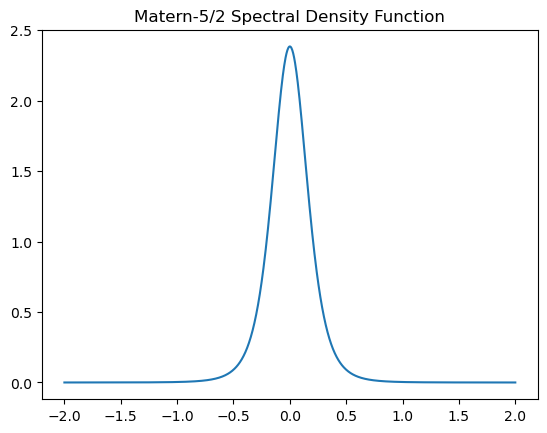

In [7]:
ls = torch.linspace(-2,2,1000)
ss = s(ls)
plt.plot(ls.cpu(), ss.cpu())
plt.title('Matern-5/2 Spectral Density Function')


In [8]:
cdfs = cdf_s(ls)

Text(0, 0.5, '$CDF_S$')

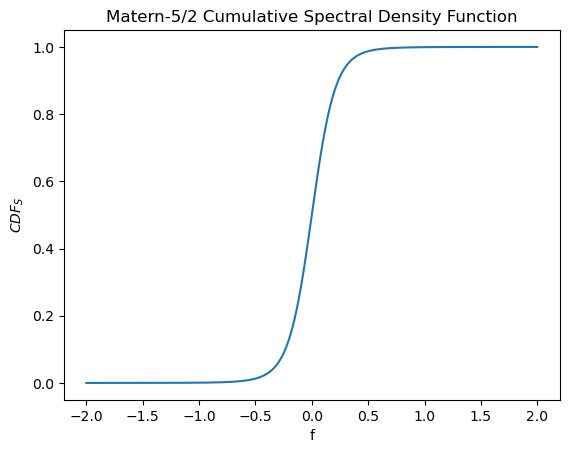

In [9]:
plt.plot(ls.cpu(),cdfs.cpu())
plt.title('Matern-5/2 Cumulative Spectral Density Function')
plt.xlabel('f')
plt.ylabel('$CDF_S$')

In [10]:
#this is slow but could be pre-computed
cdfs = torch.rand(size=[1000])
fs = torch.Tensor(np.array([inv_cdf_s(cdf) for cdf in cdfs])).double().reshape(-1)
bs = torch.rand(size=[fs.shape[0]])*2*torch.pi

Text(0.5, 1.0, 'Inverse Transform Sampling (step 1)')

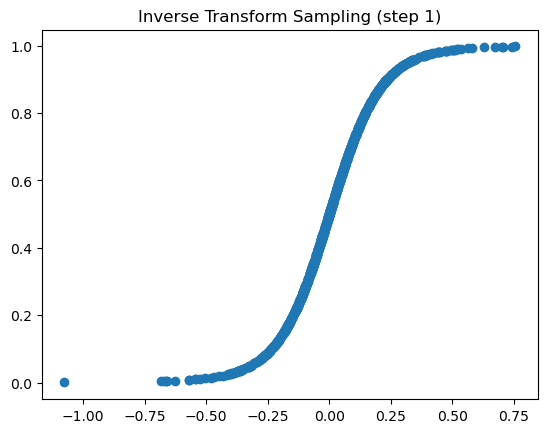

In [11]:
plt.scatter(fs, cdfs)
plt.title('Inverse Transform Sampling (step 1)')

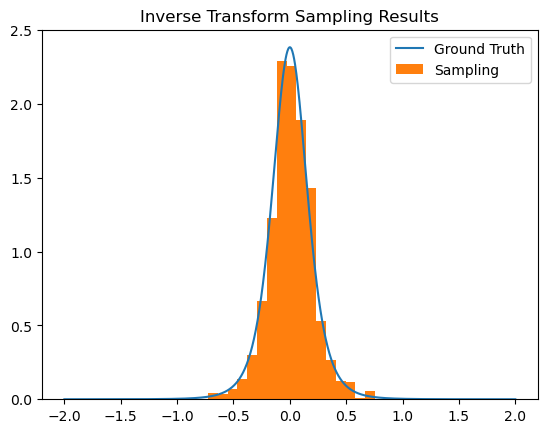

In [12]:
ls = torch.linspace(-2,2,1000)
ss = s(ls)
plt.plot(ls, ss, label='Ground Truth')
plt.hist(fs.numpy(), bins=21, density=True, label='Sampling')
plt.title('Inverse Transform Sampling Results')
plt.legend()

In [13]:
ws = torch.randn(size=[fs.shape[0]])


In [14]:
def weight_space_prior(xs, ws, fs, bs):
    global kernel_scale
    global lengthscale
    l = ws.shape[0] #the number of basis functions
    X = xs.reshape(1,-1).repeat([fs.shape[0],1]).double()
    W = ws.repeat([X.shape[1],1]).T
    B = bs.repeat([X.shape[1],1]).T
    phis = W*torch.sqrt(kernel_scale)*torch.cos(2*torch.pi/lengthscale*torch.matmul(X.T,torch.diag(fs)).T + B)
    phis = phis.double()
    return (2./l)**(0.5)*torch.sum(phis, dim=0)

xs = torch.linspace(-5,5,100)
ys_prior = weight_space_prior(xs, ws, fs, bs)

Text(0.5, 1.0, 'Matern Weight-Space Prior Sample')

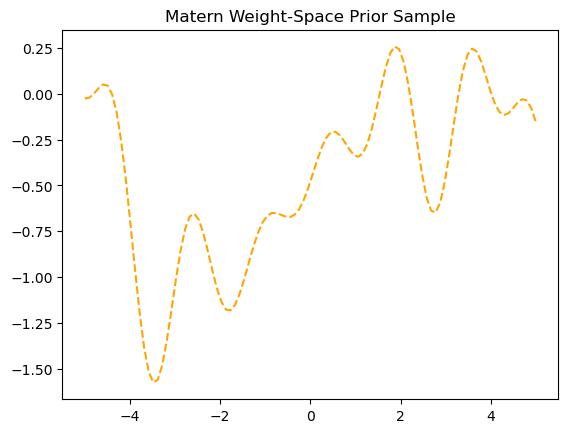

In [15]:
plt.plot(xs, ys_prior, c='orange', linestyle='--')
plt.title('Matern Weight-Space Prior Sample')

In [16]:
def some_func(x):
    return 0.05*(x**4 + 1*x**3 -16*x**2 + 8*x + 0.5) + 1

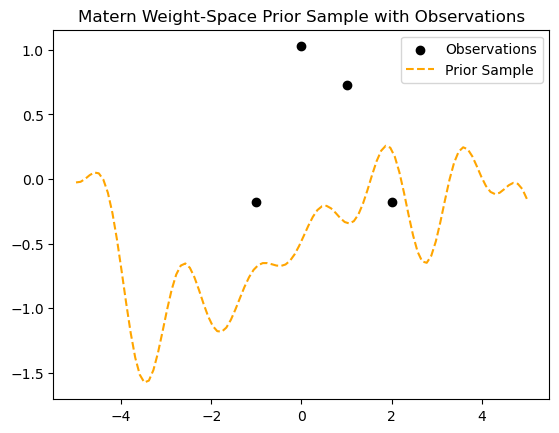

In [17]:
x_obs = torch.Tensor([-1,0,1,2]).reshape((-1,1))
y_obs = some_func(x_obs) 
plt.scatter(x_obs, y_obs, c='k', label='Observations')
plt.plot(xs, ys_prior, c='orange', linestyle='--', label='Prior Sample')
plt.title('Matern Weight-Space Prior Sample with Observations')
plt.legend()

In [18]:
kernel = gpytorch.kernels.MaternKernel()
kernel = gpytorch.kernels.ScaleKernel(kernel)
kernel.base_kernel.lengthscale = lengthscale
kernel.outputscale = kernel_scale
Knn = kernel.forward(x_obs, x_obs)

In [19]:
sigma = 0.05

K = Knn + sigma**2*torch.eye(Knn.shape[0])
K=K.double()

prior_residual = y_obs - weight_space_prior(x_obs, ws, fs, bs).reshape(-1,1)
prior_residual -= sigma*torch.randn_like(prior_residual)
prior_residual=prior_residual.double()

In [20]:
v = torch.linalg.solve(K, prior_residual) #replace with cholesky approach

K_update = kernel.forward(x_obs, xs.reshape(-1,1)).double() #remove forward

update = torch.matmul(v.T, K_update).reshape(-1).detach()

In [21]:
updated_ys_prior = ys_prior + update

Text(0.5, 1.0, 'Weight-Space Prior Plus Function-Space Update')

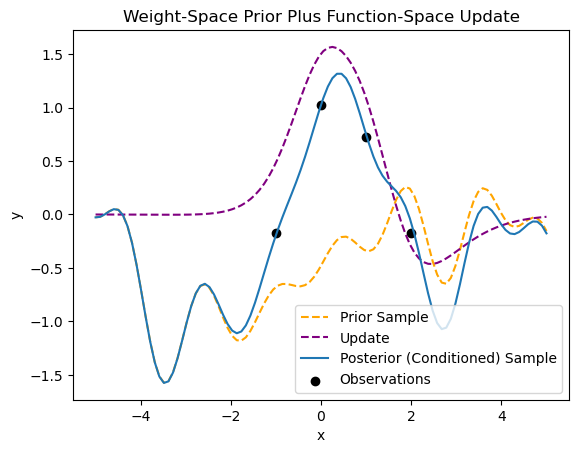

In [22]:
plt.plot(xs, ys_prior, c='orange', linestyle='--', label='Prior Sample')
plt.plot(xs, update, c='purple', linestyle='--', label='Update')
plt.plot(xs, updated_ys_prior, c='C0', label='Posterior (Conditioned) Sample')
plt.scatter(x_obs, y_obs, c='k', label='Observations')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Weight-Space Prior Plus Function-Space Update')

In [23]:
nsamples = 1000

updated_samples = torch.Tensor([])
original_samples = torch.Tensor([])
for i in range(nsamples): #need to torchify with tensor/matrix multiplication
    ws = torch.randn(size=[fs.shape[0]])
    ys_prior = weight_space_prior(xs, ws, fs, bs)
    prior_residual = y_obs - weight_space_prior(x_obs, ws, fs, bs).reshape(-1,1)
    prior_residual -= sigma*torch.randn_like(prior_residual)
    prior_residual=prior_residual.double()

    v = torch.linalg.solve(K, prior_residual)

    K_update = kernel.forward(x_obs, xs.reshape(-1,1)).double()

    update = torch.matmul(v.T, K_update).reshape(-1).detach()
    
    updated_ys_prior = ys_prior + update
    
    original_samples = torch.cat((original_samples, ys_prior.reshape(1,-1)), dim=0)
    updated_samples = torch.cat((updated_samples, updated_ys_prior.reshape(1,-1)), dim=0)
    
# plt.plot(xs,updated_samples[0], c='C0', alpha=0.2, label='Samples')
# for sample in updated_samples[1:]:
#     plt.plot(xs, sample, c='C0', alpha=0.2)
# plt.scatter(x_obs, y_obs, c='k', label='Observations')
# plt.title('Conditioned Sample Paths')
# plt.legend()

In [24]:
from botorch.models.transforms.input import InputStandardize
from botorch.models.transforms.outcome import Standardize
from botorch.models import SingleTaskGP

covar_module = gpytorch.kernels.MaternKernel(nu=2.5)

scaled_covar_module = gpytorch.kernels.ScaleKernel(covar_module)

########################################
#mean

#     constant_constraint = gpytorch.constraints.GreaterThan(50.)
#     constant_constraint = gpytorch.constraints.Positive()
#     constant_prior = gpytorch.priors.GammaPrior(10,10)
constant_constraint = None
constant_prior = None
mean_module = gpytorch.means.ConstantMean(constant_prior = constant_prior, constant_constraint=constant_constraint)
#     mean_module = None
########################################
#noise/likelihood

noise_prior = gpytorch.priors.GammaPrior(1,10)
#     noise_prior = None
noise_constraint = None
#     noise_constraint = gpytorch.constraints.GreaterThan(0.01)

likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_prior=noise_prior, noise_constraint=noise_constraint)

########################################
#transforms

# outcome_transform = Standardize(m=1)
# input_transform = InputStandardize(d=x_obs.shape[-1])  
outcome_transform = None
input_transform = None

########################################
#model

model = SingleTaskGP(x_obs, y_obs, likelihood, mean_module = mean_module, covar_module = scaled_covar_module, 
                     outcome_transform = outcome_transform, input_transform = input_transform)

model.mean_module.constant = torch.tensor(0.)

model.covar_module.base_kernel.lengthscale = lengthscale

likelihood.noise = torch.tensor(0.05**2)

model.covar_module.outputscale = kernel_scale


C:\Users\Dylan\SLAC\botorch-bax\botorch\models\gpytorch.py:113: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(


In [25]:
with torch.no_grad():
    p = model.posterior(xs.reshape(-1,1))
    s = p.rsample(torch.Size([nsamples])).reshape(nsamples, -1)
s.shape

torch.Size([1000, 100])

In [26]:
# fig, axs = plt.subplots(2)

# ax = axs[0]
# ax.plot(xs,s[0], c='C0', alpha=0.2, label='Samples')
# for sample in s[1:]:
#     ax.plot(xs, sample, c='C0', alpha=0.2)
# ax.scatter(x_obs, y_obs, c='k', label='Observations')
# ax.set_title('BoTorch Built-in Sampling')
# ax.legend()


# ax = axs[1]
# ax.plot(xs,updated_samples[0], c='C0', alpha=0.2, label='Samples')
# for sample in updated_samples[1:]:
#     ax.plot(xs, sample, c='C0', alpha=0.2)
# ax.scatter(x_obs, y_obs, c='k', label='Observations')
# ax.set_title('Pathwise (Efficient) Sampling')
# ax.legend()

# plt.tight_layout()

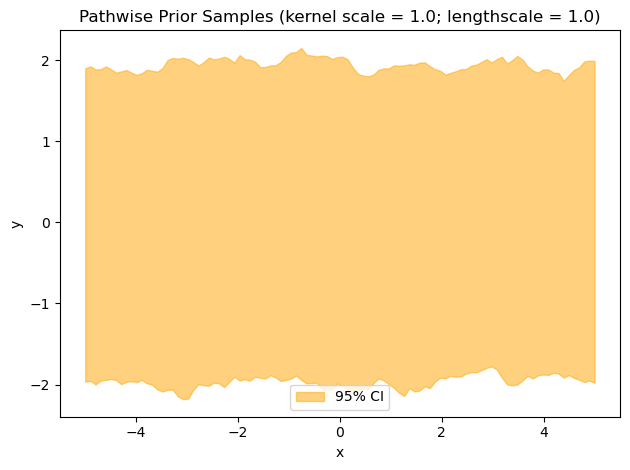

In [27]:
fig, ax = plt.subplots(1)


ax.fill_between(xs, torch.quantile(original_samples, 0.025, dim=0), torch.quantile(original_samples, 0.975, dim=0), color='orange', alpha =0.5, label='95% CI')

# ax.plot(xs, torch.quantile(original_samples, 0.975, dim=0), c='k', linestyle='--', label='Pathwise (Custom) 95% CI')
# ax.plot(xs, torch.quantile(original_samples, 0.025, dim=0), c='k', linestyle='--')

# ax.scatter(x_obs, y_obs, c='k', label='Observations')
ax.legend(loc='lower center')


ax.set_title('Pathwise Prior Samples (kernel scale = ' + str((kernel_scale).numpy()) + '; lengthscale = ' + str(lengthscale.numpy()) + ')')
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.tight_layout()

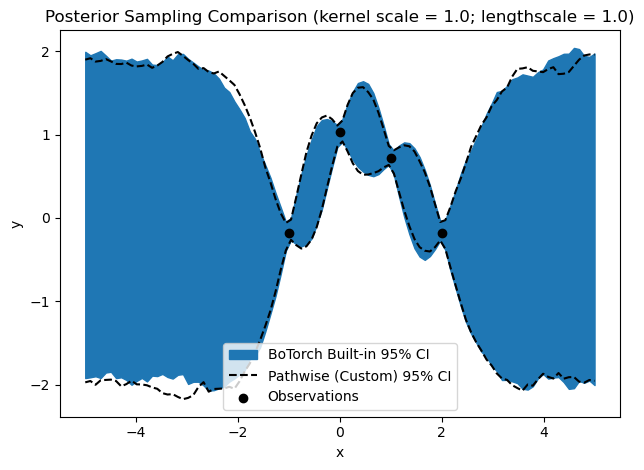

In [28]:
fig, ax = plt.subplots(1)


ax.fill_between(xs, torch.quantile(s, 0.025, dim=0), torch.quantile(s, 0.975, dim=0), color='C0', label='BoTorch Built-in 95% CI')

ax.plot(xs, torch.quantile(updated_samples, 0.975, dim=0), c='k', linestyle='--', label='Pathwise (Custom) 95% CI')
ax.plot(xs, torch.quantile(updated_samples, 0.025, dim=0), c='k', linestyle='--')

ax.scatter(x_obs, y_obs, c='k', label='Observations')
ax.legend(loc='lower center')


ax.set_title('Posterior Sampling Comparison (kernel scale = ' + str((kernel_scale).numpy()) + '; lengthscale = ' + str(lengthscale.numpy()) + ')')
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.tight_layout()

In [29]:
def quad_basis(x):
    c = torch.tensor(0.)
    return torch.concat([x * x, (2 * c).sqrt() * x, c.expand(*x.shape)], dim=-1)

In [30]:
x = torch.linspace(0,1,10).reshape(-1,1)

quad_basis(x)

tensor([[0.0000, 0.0000, 0.0000],
        [0.0123, 0.0000, 0.0000],
        [0.0494, 0.0000, 0.0000],
        [0.1111, 0.0000, 0.0000],
        [0.1975, 0.0000, 0.0000],
        [0.3086, 0.0000, 0.0000],
        [0.4444, 0.0000, 0.0000],
        [0.6049, 0.0000, 0.0000],
        [0.7901, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000]])

In [31]:
import botorch
from botorch.sampling.pathwise import (
    fourier_feature_initializer,
    GeneralizedLinearBasis,
)

In [32]:
from botorch.sampling.pathwise.matheron import draw_matheron_paths

In [33]:

paths = draw_matheron_paths(model, torch.Size([nsamples]))

In [34]:
metheron_ys = paths(xs.reshape(-1,1))

In [35]:
metheron_ys = metheron_ys.reshape(nsamples, -1).detach()

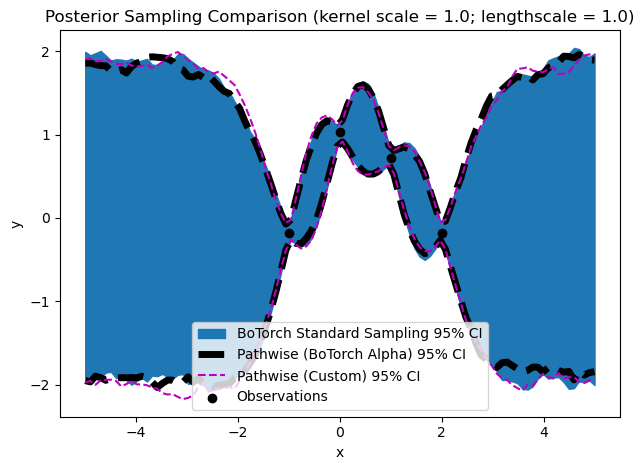

In [36]:
fig, ax = plt.subplots(1)


ax.fill_between(xs, torch.quantile(s, 0.025, dim=0), torch.quantile(s, 0.975, dim=0), color='C0', label='BoTorch Standard Sampling 95% CI')


ax.plot(xs, torch.quantile(metheron_ys, 0.975, dim=0), c='k', linestyle='--', linewidth=5, label='Pathwise (BoTorch Alpha) 95% CI')
ax.plot(xs, torch.quantile(metheron_ys, 0.025, dim=0), c='k', linestyle='--', linewidth=5)


ax.plot(xs, torch.quantile(updated_samples, 0.975, dim=0), c='m', linestyle='--', label='Pathwise (Custom) 95% CI')
ax.plot(xs, torch.quantile(updated_samples, 0.025, dim=0), c='m', linestyle='--')

ax.scatter(x_obs, y_obs, c='k', label='Observations')
ax.legend(loc='lower center')


ax.set_title('Posterior Sampling Comparison (kernel scale = ' + str((kernel_scale).numpy()) + '; lengthscale = ' + str(lengthscale.numpy()) + ')')
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.tight_layout()

In [48]:
from gpytorch.kernels import PolynomialKernel
ws_quad = torch.randn(size=[3])
quad_kernel = PolynomialKernel(power=2)

quad_kernel = gpytorch.kernels.ScaleKernel(quad_kernel)
quad_kernel.outputscale = kernel_scale

def quadratic_weight_space_prior(xs, ws, kernel):
    global kernel_scale
    global lengthscale
    c = quad_kernel.base_kernel.offset
#     print('offset = ', c)
    l = 3 #the number of basis functions
    X = xs.reshape(1,-1).double()
#     print(X.shape)
    W = ws.repeat([X.shape[1],1]).T
#     print(W.shape)
    phis = W*torch.sqrt(kernel_scale)*torch.concat([X * X, (2 * c).sqrt() * X, c.expand(*X.shape)], dim=0)
    phis = phis.double()
    return torch.sum(phis, dim=0)

xs = torch.linspace(-5,5,100)
ys_prior = quadratic_weight_space_prior(xs, ws_quad, quad_kernel)

Text(0.5, 1.0, 'Quadratic Weight-Space Prior Sample')

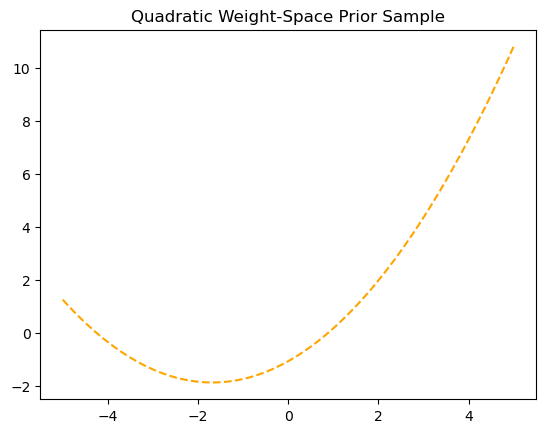

In [49]:
plt.plot(xs, ys_prior.detach(), c='orange', linestyle='--')
plt.title('Quadratic Weight-Space Prior Sample')

In [54]:
Knn = quad_kernel.forward(x_obs, x_obs)

sigma = 0.05

K = Knn + sigma**2*torch.eye(Knn.shape[0])
K=K.double()

prior_residual = y_obs - quadratic_weight_space_prior(x_obs, ws_quad, quad_kernel).reshape(-1,1)
prior_residual -= sigma*torch.randn_like(prior_residual)
prior_residual=prior_residual.double()

v = torch.linalg.solve(K, prior_residual) #replace with cholesky approach

K_update = quad_kernel.forward(x_obs, xs.reshape(-1,1)).double() #remove forward

update = torch.matmul(v.T, K_update).reshape(-1).detach()

updated_ys_prior = ys_prior + update



Text(0.5, 1.0, 'Weight-Space Prior Plus Function-Space Update')

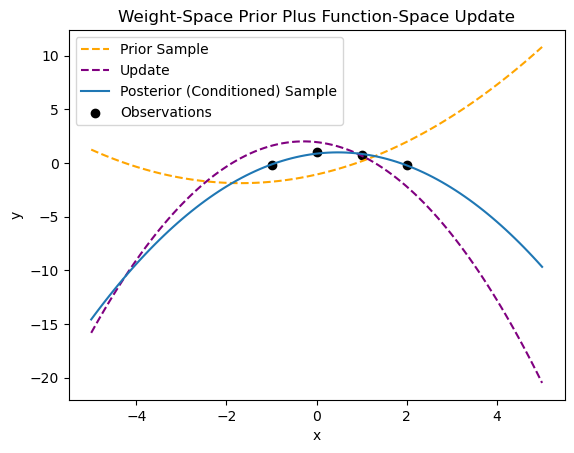

In [55]:
plt.plot(xs, ys_prior.detach(), c='orange', linestyle='--', label='Prior Sample')
plt.plot(xs, update.detach(), c='purple', linestyle='--', label='Update')
plt.plot(xs, updated_ys_prior.detach(), c='C0', label='Posterior (Conditioned) Sample')
plt.scatter(x_obs, y_obs, c='k', label='Observations')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Weight-Space Prior Plus Function-Space Update')

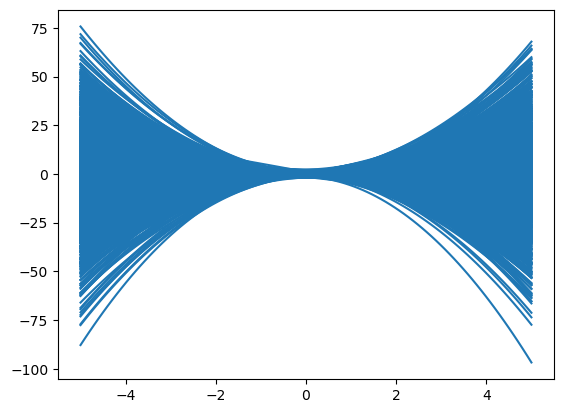

In [39]:
nsamples = 1000

# updated_samples = torch.Tensor([])
original_samples = torch.Tensor([])
for i in range(nsamples): #need to torchify with tensor/matrix multiplication
    ws_quad = torch.randn(size=[3])
    ys_prior = quadratic_weight_space_prior(xs, ws_quad, quad_kernel)
#     prior_residual = y_obs - weight_space_prior(x_obs, ws, fs, bs).reshape(-1,1)
#     prior_residual -= sigma*torch.randn_like(prior_residual)
#     prior_residual=prior_residual.double()

#     v = torch.linalg.solve(K, prior_residual)

#     K_update = kernel.forward(x_obs, xs.reshape(-1,1)).double()

#     update = torch.matmul(v.T, K_update).reshape(-1).detach()
    
#     updated_ys_prior = ys_prior + update
    
    original_samples = torch.cat((original_samples, ys_prior.reshape(1,-1)), dim=0)
    
original_samples = original_samples.detach()

for s in original_samples:
    plt.plot(xs, s, c='C0')

In [40]:
prior_samples = torch.Tensor([])
for i in range(nsamples):
    Z = torch.randn(size=[100,1])
    K = quad_kernel.forward(xs.reshape(-1,1), xs.reshape(-1,1)) 
    K += + .05**2*torch.eye(K.shape[0])
    A = torch.linalg.cholesky(K)
    sample = torch.matmul(A,Z)
    prior_samples = torch.cat((prior_samples, sample.reshape(1,-1)), dim=0)
    
prior_samples = prior_samples.detach()


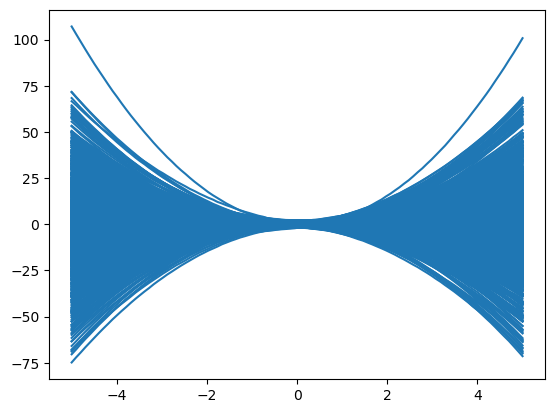

In [41]:
for sample in prior_samples:
    plt.plot(xs, sample, c='C0')

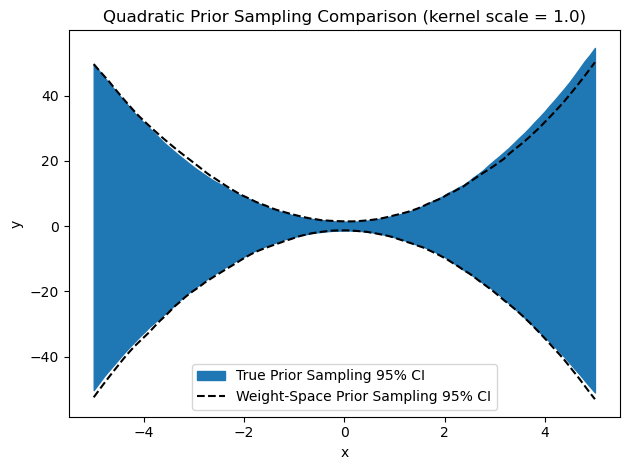

In [42]:
fig, ax = plt.subplots(1)


ax.fill_between(xs, torch.quantile(prior_samples, 0.025, dim=0), torch.quantile(prior_samples, 0.975, dim=0), color='C0', label='True Prior Sampling 95% CI')


ax.plot(xs, torch.quantile(original_samples, 0.975, dim=0), c='k', linestyle='--', label='Weight-Space Prior Sampling 95% CI')
ax.plot(xs, torch.quantile(original_samples, 0.025, dim=0), c='k', linestyle='--')


# ax.scatter(x_obs, y_obs, c='k', label='Observations')
ax.legend(loc='lower center')


ax.set_title('Quadratic Prior Sampling Comparison (kernel scale = ' + str((kernel_scale).numpy()) + ')')
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.tight_layout()